In [17]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pennylane as qml

In [2]:
data = {}

dpath = r'C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\ADAPT-VQE\Files\DW\DW_16.json'
with open(dpath, 'r') as json_file:
    data = json.load(json_file)

In [34]:
data_dict = {}

cutoff = data['cutoff']
potential = data['potential']

print(f"Finding optimal circuit for {potential} - cutoff {cutoff}")

num_qubits = int(np.log2(cutoff)) + 1
min_eigenvalue = min(data['exact_eigenvalues'])

# Only consider data that has converge to min energy
mask = []
for d in data['min_energies']:
    if abs(d - min_eigenvalue) < 1e-6:
        mask.append(True)
    else:
        mask.append(False)

# Clean and prepare circuit data
d_ops = [op.replace('))',')') for op in data['op_list']]
min_ops = [op_list for op_list, keep in zip(d_ops, mask) if keep]
min_ops = [eval(ops, {"RY": qml.RY, "CRX": qml.CRX, "CRY": qml.CRY, "np": np}) for ops in min_ops]
energies = [op_list for op_list, keep in zip(data['all_energies'], mask) if keep]

# Find op list with minimum number of gates
min_len = min([len(ops) for ops in min_ops])
reduced = [ops for ops in min_ops if len(ops) == min_len]

# Take the unique circuits
unique = []
for op_list in reduced:
    if op_list not in unique:
        unique.append(op_list)


basis_state = data['basis_state']

data_dict['potential'] = potential
data_dict['cutoff'] = cutoff
data_dict['basis_state'] = basis_state
data_dict['circuits'] = unique
data_dict['energies'] = energies



Finding optimal circuit for DW - cutoff 16


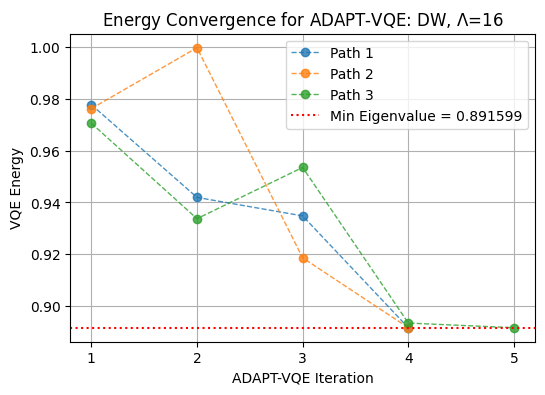

In [36]:
plt.figure(figsize=(6,4))

d_ops = []
d_energies = []

legend_idx = 1
for i, position in zip([1, 33,-1],['left','right','center']):

    ops = min_ops[i]
    op_labels = []

    for op in ops:
        
        wires = op.wires
        if len(wires) > 1:
            label = f'CRY({str(wires[0])},{str(wires[1])})'
        else:
            label = f"{op.label()}({str(wires[0])})"

        op_labels.append(label)


    energy_list = energies[i]

    d_ops.append(op_labels)
    d_energies.append(energy_list)

    plt.plot(range(1, len(energy_list) + 1), energy_list, marker='o', linestyle='--', alpha=0.8, linewidth=1, label=f'Path {legend_idx}')
    legend_idx +=1
    

    #for i, op in enumerate(op_labels):
    #    plt.annotate(op, (i + 1, energy_list[i]), textcoords="offset points", xytext=(0,6), ha=position, fontsize=6, color='black')

    #plt.tight_layout()
    
plt.axhline(y=min_eigenvalue, color='red', linestyle=':', label=f'Min Eigenvalue = {min_eigenvalue:.6f}')
plt.xlabel('ADAPT-VQE Iteration')
plt.xticks(range(1, len(energy_list)  + 1))
plt.ylabel('VQE Energy')
plt.title(f"Energy Convergence for ADAPT-VQE: {potential}, $\\Lambda$={cutoff}")
plt.grid(True)
plt.legend()
#plt.show()
plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\ADAPT-VQE\Files\OpPath.png")


In [37]:
data_dict = {'Path': ['1', '2', '3'],
      'Operators': d_ops,
      'Energy': d_energies}

In [49]:
max_steps = max(len(ops) for ops in data_dict['Operators'])
rows = []

for i in range(max_steps):
    row = {}
    for path_idx, path in enumerate(data_dict['Path']):
        ops = data_dict['Operators'][path_idx]
        energies = data_dict['Energy'][path_idx]
        if i < len(ops):
            row[f'Path {path}'] = f"{ops[i]} ({energies[i]:.6f})"
        else:
            row[f'Path {path}'] = None
    rows.append(row)

df = pd.DataFrame(rows)
df = df.reset_index().rename(columns={'index':'Step'})
df['Step'] = df['Step'] + 1
df


,Step,Path 1,Path 2,Path 3
0,1,RY(4) (0.977755),RY(4) (0.976220),RY(4) (0.970607)
1,2,"CRY(4,3) (0.941934)","CRY(4,3) (0.999746)","CRY(4,3) (0.933711)"
2,3,RY(2) (0.934783),RY(4) (0.918589),RY(2) (0.953504)
3,4,RY(3) (0.891599),RY(2) (0.891599),RY(3) (0.893399)
4,5,None,None,RY(1) (0.891599)


In [50]:
from tabulate import tabulate
latex_table = tabulate(df.values, headers=df.columns, tablefmt="latex")#, floatfmt=".3f")
print(latex_table)


\begin{tabular}{rlll}
\hline
   Step & Path 1              & Path 2              & Path 3              \\
\hline
      1 & RY(4) (0.977755)    & RY(4) (0.976220)    & RY(4) (0.970607)    \\
      2 & CRY(4,3) (0.941934) & CRY(4,3) (0.999746) & CRY(4,3) (0.933711) \\
      3 & RY(2) (0.934783)    & RY(4) (0.918589)    & RY(2) (0.953504)    \\
      4 & RY(3) (0.891599)    & RY(2) (0.891599)    & RY(3) (0.893399)    \\
      5 &                     &                     & RY(1) (0.891599)    \\
\hline
\end{tabular}
